In [16]:
# http://imaimamu.com/archives/2027

from __future__ import division, print_function, absolute_import, unicode_literals
import pandas as pd
from pandas import DataFrame, Series
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
# y: 種子数
# x: 体サイズ
# f: 施肥
d = pd.read_csv('../data/data3a.csv')
d

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C
...,...,...,...
95,8,9.15,T
96,6,8.52,T
97,8,10.24,T
98,7,10.86,T


In [3]:
# 使い方。formulaは目的変数と説明変数の間の関係を式で表現できる
# https://wcs.hatenablog.com/entry/2016/11/08/231703
fit1 = smf.glm(formula='y ~ 1', data=d, family=sm.families.Poisson()).fit()
fit2 = smf.glm(formula='y ~ x', data=d, family=sm.families.Poisson()).fit()

In [4]:
# 残渣逸脱度
print(fit2.deviance)

# 逸脱度の差(ΔD_1,2)
print(fit1.deviance - fit2.deviance)

84.9929964907296
4.51394107885173


統計的な検定では帰無仮説が真のモデルであるとみなす
帰無仮説である一定モデルで推定された平均種子数は7.85個だったので、
真のモデルから生成されるでーたは「平均7.85の100個のポアソン乱数」

In [5]:
# (1)
d2 = d
d2['y_rnd'] = np.random.poisson(d.y.mean(), 100)
d2

,y,x,f,y_rnd
0,6,8.31,C,7
1,6,9.44,C,12
2,6,9.50,C,5
3,12,9.07,C,8
4,10,10.16,C,9
...,...,...,...,...
95,8,9.15,T,8
96,6,8.52,T,9
97,8,10.24,T,5
98,7,10.86,T,3


In [6]:
# 体サイズxと関係ない平均値一定のポアソン乱数であるデータに対しても、逸脱度の差が1.92となる
# (2)
fit2_1 = smf.glm(formula='y_rnd ~ 1', data=d2, family=sm.families.Poisson()).fit()
fit2_2 = smf.glm(formula='y_rnd ~ x', data=d2, family=sm.families.Poisson()).fit()
# (3)
print(fit2_1.deviance - fit2_2.deviance)

1.968532121150659


「真のモデル」である一定モデルよりも無意味な説明変数を持つxモデルの方が当てはまりが良くなる
逸脱度(fitX.deviance)は大きいと、当てはまりが悪いという表現。
fit2_1.deviance - fit2_2.devianceが正の数だとfit2_1の方が逸脱度が大きい=一定モデルの方が逸脱度が大きい
よって、「一定モデルよりも無意味な説明変数を持つxモデルの方が当てはまりが良くなる」
(1)-(3)までを1000回繰り返すと「検定統計量の分布」(逸脱度の差ΔD1,2)の分布を予測できる

In [7]:
def get_delta_d(data: DataFrame) -> float:
    data['y_rnd'] = np.random.poisson(d.y.mean(), 100)
    fit1 = smf.glm(formula='y_rnd ~ 1', data=data, family=sm.families.Poisson()).fit()
    fit2 = smf.glm(formula='y_rnd ~ x', data=data, family=sm.families.Poisson()).fit()
    return fit1.deviance - fit2.deviance

def calculate_parametric_bootstrap(data: DataFrame, cnt: int) -> Series:
    return pd.Series([get_delta_d(data) for i in range(cnt)])

dd12 = calculate_parametric_bootstrap(d, 1000)
dd12.describe()

count    1.000000e+03
mean     1.016693e+00
std      1.432676e+00
min      4.607504e-08
25%      1.091354e-01
50%      4.948534e-01
75%      1.319796e+00
max      1.128188e+01
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

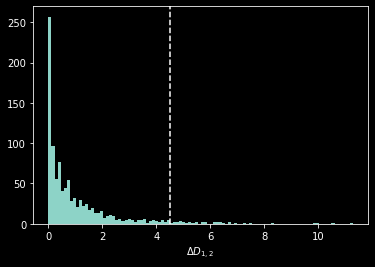

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(dd12, 100)
ax.set_xlabel(r'$\Delta D_{1,2}$')
plt.axvline(x=4.5, linestyle='--')
plt.show

In [18]:
# 1000個のうち幾つが4.5以上あるのか
print((dd12 >= 4.5).sum())


38


In [19]:
# P=0.05の位置にあるΔD1,2。出力される値まではよくある差としてみなされる
print(dd12.quantile(0.95))

3.9993589856720386


結論として「逸脱度の差4.5のPの値は0.038だったので、これは有意水準0.05より小さい」ので有意差がある。

「帰無仮説(一定モデル)は棄却され、xモデルが残るのでこれを採択」

